In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
url = "https://raw.githubusercontent.com/anoushavan/Capstone_1/master/data/new_buildings.csv"

data = pd.read_csv(url, parse_dates=['Fully Paid','Approved','SIGNOFF_DATE'])

/Users/anushavan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118461 entries, 0 to 118460
Data columns (total 21 columns):
Borough                          118461 non-null object
Building Type                    118461 non-null object
eFiling Filed                    49594 non-null object
Applicant Professional Title     118456 non-null object
Professional Cert                84910 non-null object
Fully Paid                       117514 non-null datetime64[ns]
Approved                         70616 non-null datetime64[ns]
Total Est. Fee                   118461 non-null object
Proposed Zoning Sqft             118461 non-null int64
Proposed No. of Stories          118461 non-null int64
Proposed Height                  118461 non-null int64
Proposed Dwelling Units          68282 non-null object
Proposed Occupancy               79917 non-null object
Zoning Dist1                     79917 non-null object
Zoning Dist2                     6244 non-null object
Zoning Dist3                     247 non-nul

### Clean up the dataframe

* converting all column names to *title case*, <br> 
* converting numeric data into numeric form by removing dollar signs and converting to intiger, <br> 
* creating a **"Duration"** column measuring the duration of the approval process as the difference between the "Approved" and "Fully Paid" columns <br> 
* creating subsets of data to hold normal values, values that are below 0 (meaningless) and zero values.
* Transform "Boroughs" into category to increase the speed of execution.

In [5]:
# Convert all data columns to Title Case
data.columns = data.columns.str.title()

# Convert Total Est. Fee to float data and remove $ symbol 
data['Total Est. Fee']= [float(c.replace('$','')) for c in data['Total Est. Fee']]

In [6]:
# Convert Proposed Dwelling Units to integers
data['Proposed Dwelling Units'] = (pd.to_numeric(data
                                  ['Proposed Dwelling Units'], errors='coerce'))


In [7]:
# Create a Duration column and convert it to integers (instead of days)
data['Duration'] = (data['Approved'] - data['Fully Paid']).dt.days

In [8]:
# Subset of data where the Duration is more than 0 days
data = data[data['Duration'] > 0]

# Subset of data where the Duration is less then 0 days
odd_data = data[data['Duration'] < 0]

# Subset of data where the Duration is 0 days
zero_data = data[data['Duration'] == 0]

In [9]:
# transform the Boroughs into categories for faster analysis.
data['Borough'] = data['Borough'].astype('category')

#### Dealing with blank (NaN/NaT) values

converting the NaN values to N string indicating No.

In [10]:
# Column Efiling Filed: replace the NaN values with N (No)
data['Efiling Filed'] = data['Efiling Filed'].fillna('N')

In [11]:
data['Professional Cert'] = data['Professional Cert'].fillna('N')

##### Potential columns to drop
The column "Proposed Dwelling Units" has 50392 not null values.

The columnn "Fully Permitted" has 7070 NaT entries.


##### Drop rows
There are 2 rows in the "Applicant Professional Title" column that are blank. Assigned them
to del_rows variable and deleted. 

There are also 2 rows in the Processional Cert column that are not Y or N, they should be dropped.

In [12]:
del_rows = data[data['Applicant Professional Title'].isnull()].index
data.drop(del_rows, inplace=True)
data = (data.drop(data[(data['Professional Cert'] == 'J') | 
                            (data['Professional Cert'] == 'R')].index))

### Analysis of data

Creating:
1. histograms (for categorical variables)
2. bar charts (for continuous variables) and 
3. boxplots for categorical variables (x axis) and a continuous variable (y axis).


In [13]:
data.head(2)

,Borough,Building Type,Efiling Filed,Applicant Professional Title,Professional Cert,Fully Paid,Approved,Total Est. Fee,Proposed Zoning Sqft,Proposed No. Of Stories,...,Proposed Occupancy,Zoning Dist1,Zoning Dist2,Zoning Dist3,Special District 1,Special District 2,Non-Profit,Total_Construction_Floor_Area,Signoff_Date,Duration
0,QUEENS,1-2-3 FAMILY,Y,RA,N,2018-11-02,2019-04-09,243.00,2700,2,...,R-3,R3A,NaN,NaN,NaN,NaN,N,4050,NaT,158.0
1,BROOKLYN,OTHERS,Y,RA,N,2012-03-27,2013-03-14,52167.26,161567,14,...,R-1,M1-2/R6,NaN,NaN,MX-8,GW,N,198951,NaT,352.0


,Borough
MANHATTAN,2224
BRONX,7417
STATEN ISLAND,11359
BROOKLYN,17062
QUEENS,21014


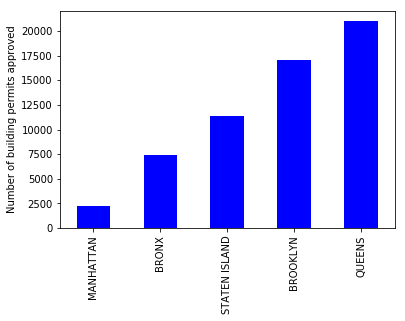

In [71]:
# create a bar plot for the # of building permits issued by Borough
ax = data['Borough'].value_counts().sort_values().plot(kind='bar', color = 'b')
ax.set_ylabel('Number of building permits approved')
ax.set_xlabel('')
pd.DataFrame(data['Borough'].value_counts(ascending=True))

,mean,std,max
Borough,,,
BRONX,165.0,254.0,3478.0
BROOKLYN,179.0,227.0,2762.0
MANHATTAN,333.0,336.0,3585.0
QUEENS,154.0,237.0,3637.0
STATEN ISLAND,143.0,315.0,4959.0


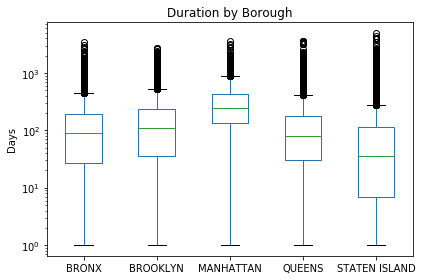

In [88]:
# Create a boxplot of Building Type Duration.
ax = data.boxplot(column=['Duration'], by=['Borough'])
plt.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('Days')
ax.grid(False)
ax.set_title('Duration by Borough')
ax.set_yscale('log')
plt.tight_layout()
pd.DataFrame(data.groupby('Borough')['Duration'].
             describe().loc[:,['mean','std','max']].round())

,Building Type
1-2-3 FAMILY,42311
OTHERS,16765


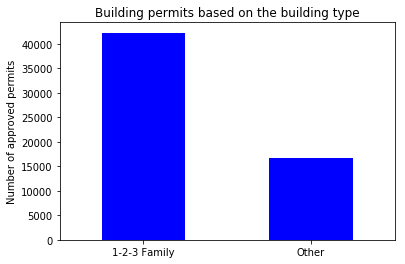

In [89]:
# Create a bar plot of Building Type and include a statistical analysis.
ax = data['Building Type'].value_counts().plot(kind='bar', color='b')
ax.set_xticklabels(['1-2-3 Family', 'Other'],rotation=360)
ax.set_title('Building permits based on the building type')
ax.set_ylabel('Number of approved permits')
pd.DataFrame(data['Building Type'].value_counts())

,mean,std,max
Building Type,,,
1-2-3 FAMILY,138.0,248.0,4959.0
OTHERS,241.0,274.0,3637.0


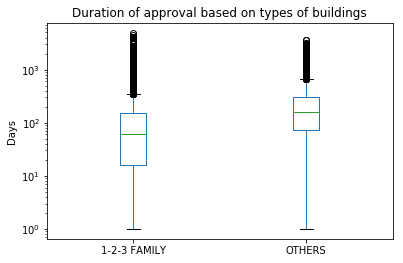

In [94]:
# Create a boxplot of Building Type Duration.
ax = data.boxplot(column=['Duration'], by=['Building Type'])
ax.set_title('Duration of approval based on types of buildings')
ax.set_xlabel('')
ax.set_ylabel('Days')
ax.set_yscale('log')
plt.suptitle('')
ax.grid(False)


pd.DataFrame(data.groupby('Building Type')['Duration'].
             describe().loc[:,['mean','std','max']].round())

,Efiling Filed
N,37873
Y,21203


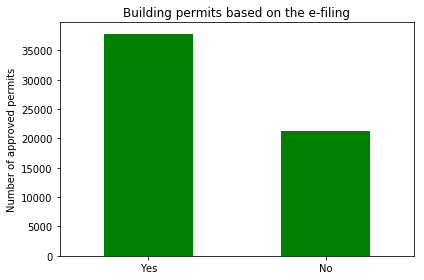

In [96]:
# Create a histogram of Efiling and include a statistical analysis.
ax = data['Efiling Filed'].value_counts().plot(kind='bar', color='g')
ax.set_xticklabels(['Yes','No'],rotation=360)
ax.set_title('Building permits based on the e-filing')
ax.set_ylabel('Number of approved permits')
plt.tight_layout()
pd.DataFrame(data['Efiling Filed'].value_counts())


,mean,std,max
Efiling Filed,,,
N,136.0,251.0,4959.0
Y,222.0,265.0,3585.0


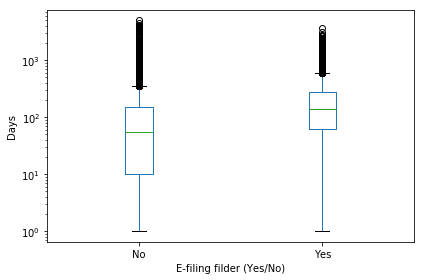

In [98]:
ax = data.boxplot(column=['Duration'], by=['Efiling Filed'])
ax.set_title('')
ax.set_ylabel('Days')
ax.set_xlabel('E-filing filder (Yes/No)')
ax.set_xticklabels(['No','Yes'])
ax.set_yscale('log')
plt.suptitle('')
ax.grid(False)
plt.tight_layout()
pd.DataFrame(data.groupby(['Efiling Filed'])['Duration'].
             describe().loc[:,['mean','std','max']].round())

,Applicant Professional Title
RA,44086
PE,14990


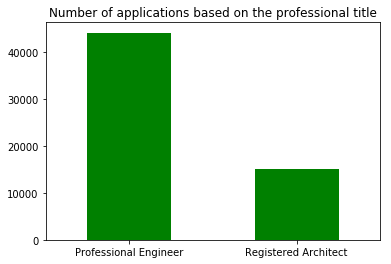

In [101]:
# Create a bar chart of Professional Title and include a statistical analysis.
ax = data['Applicant Professional Title'].value_counts().plot(kind='bar', color='g')
ax.set_xticklabels(['Professional Engineer','Registered Architect'],rotation=360)
ax.set_title('Number of applications based on the professional title')
pd.DataFrame(data['Applicant Professional Title'].value_counts())

,mean,std,max
Applicant Professional Title,,,
PE,143.0,229.0,4959.0
RA,176.0,269.0,4411.0


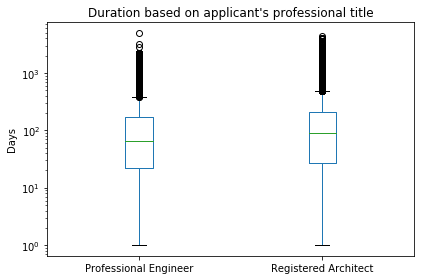

In [102]:
# Boxplot of Duration based on the applicants' professional title.
ax = data.boxplot(column=['Duration'], by=['Applicant Professional Title'])
ax.set_xticklabels(['Professional Engineer','Registered Architect'])
plt.suptitle('')
ax.set_title("Duration based on applicant's professional title")
ax.set_xlabel('')
ax.set_ylabel('Days')
ax.set_yscale('log')

ax.grid(False)
plt.tight_layout()
pd.DataFrame(data.groupby('Applicant Professional Title')['Duration'].
             describe().loc[:,['mean','std','max']].round())

,Professional Cert
N,38010
Y,21066


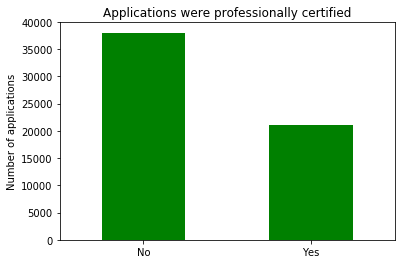

In [103]:
# Bar chart indicating whether or not the application was submitted as 
# Professionally Certified by a Professional Engineer (PE) or Registered Architect (RA).
ax = data['Professional Cert'].value_counts().plot(kind='bar', color='g')
ax.set_xticklabels(['No','Yes'],rotation=360)
ax.set_title('Applications were professionally certified')
ax.set_ylabel('Number of applications')
pd.DataFrame(data['Professional Cert'].value_counts())

,mean,std,max
Professional Cert,,,
N,225.0,283.0,4959.0
Y,62.0,166.0,2589.0


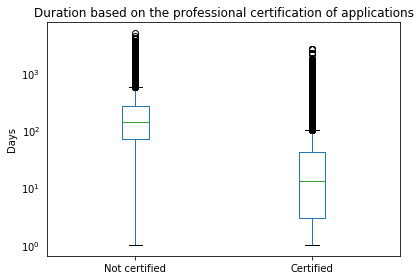

In [104]:
# Boxplot of Duration based on wheather or not the applications were professionally certified.
ax = data.boxplot(column=['Duration'], by=['Professional Cert'])
ax.set_xticklabels(['Not certified','Certified'])
plt.suptitle('')
ax.set_title("Duration based on the professional certification of applications")
ax.set_xlabel('')
ax.set_ylabel('Days')
ax.set_yscale('log')
ax.grid(False)
ax.yaxis.set_ticks_position('none')
plt.tight_layout()
pd.DataFrame(data.groupby('Professional Cert')['Duration'].
             describe().loc[:,['mean','std','max']].round())


### Discuss the result above. 

,Total Est. Fee
mean,3950.0
std,84871.0
50%,614.0


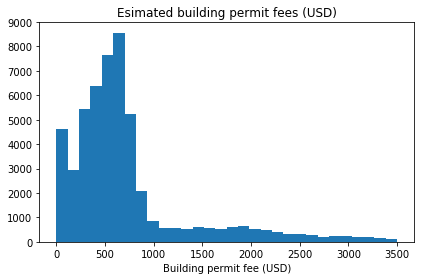

In [119]:
# Histogram of building permit fee () 
ax = data['Total Est. Fee'].hist(bins=30, range=(0,3500))
ax.set_title('Esimated building permit fees (USD)')
ax.set_xlabel('Building permit fee (USD)')
ax.grid(False)
plt.tight_layout()
pd.DataFrame(data['Total Est. Fee'].describe().loc[['mean','std','50%']].round())


#### Add a scatter plot building permit fee vs duration and the corr value

,mean,std,max
Borough,,,
STATEN ISLAND,143.0,315.0,4959.0
QUEENS,154.0,237.0,3637.0
BRONX,165.0,254.0,3478.0
BROOKLYN,179.0,227.0,2762.0
MANHATTAN,333.0,336.0,3585.0


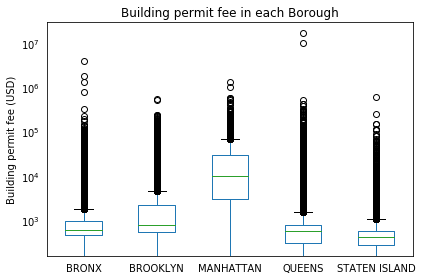

In [128]:
# Boxplot of building permit fee (estimated) in each borough.
ax = data.boxplot(column='Total Est. Fee', by='Borough')
ax.set_yscale('log')
ax.grid(False)
ax.set_title('Building permit fee in each Borough')
plt.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('Building permit fee (USD)')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.tight_layout()
(data.groupby('Borough')['Duration'].describe().
 round().loc[:,['mean','std','max']].sort_values('mean'))

/Users/anushavan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,Duration
Total Est. Fee,0.028


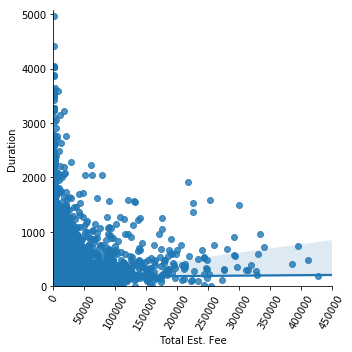

In [149]:
# scatterplot of building permit fee and Duration. 
sns.lmplot(x='Total Est. Fee', y='Duration', data=data)
plt.xlim(0,450000)
plt.ylim(0,5080)
plt.xticks(rotation=60)
plt.tight_layout()
data.corr().loc[['Total Est. Fee'],['Duration']].round(3)

/Users/anushavan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Proposed zoning area and the approval duration')

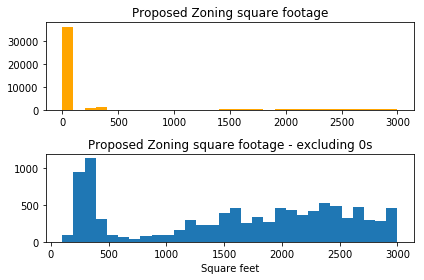

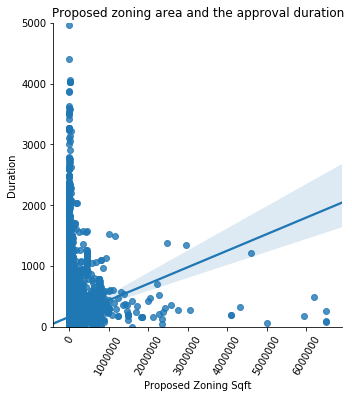

In [27]:
# Histogram of Proposed Zoning square footage. 
fig, ax = plt.subplots(2,1)

plt.subplot(2,1,1)
ax = data['Proposed Zoning Sqft'].hist(bins=30, range=(0,3000), color='orange')
ax.set_title('Proposed Zoning square footage')
# ax.set_xlabel('Square feet')
ax.grid(False)
pd.DataFrame((data['Proposed Zoning Sqft']).describe()).round(1)

plt.subplot(2,1,2)
ax1 = data['Proposed Zoning Sqft'].hist(bins=30, range=(100,3000))
ax1.set_title('Proposed Zoning square footage - excluding 0s')
ax1.set_xlabel('Square feet')
ax1.grid(False)
plt.tight_layout()

# scatterplot of proposed zoning square feet vs Duration.
sns.lmplot(x='Proposed Zoning Sqft', y='Duration', data=data)
plt.tight_layout()
# plt.xscale('log')
plt.ylim(0,5000)
plt.xticks(rotation=60)
plt.title('Proposed zoning area and the approval duration')

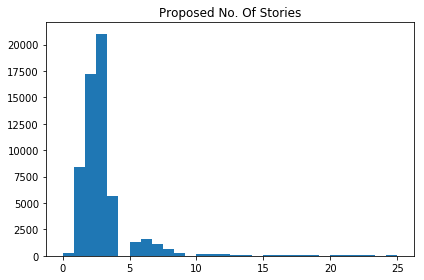

In [28]:
# Histogram of Proposed No. Of Stories. 

# DO A BAR PLOT INSTEAD OF HIST

ax = data['Proposed No. Of Stories'].hist(bins=30, range=(0,25))
ax.set_title('Proposed No. Of Stories')
ax.set_xlabel('')
ax.grid(False)
pd.DataFrame((data['Proposed No. Of Stories']).describe()).round(1)
plt.tight_layout()

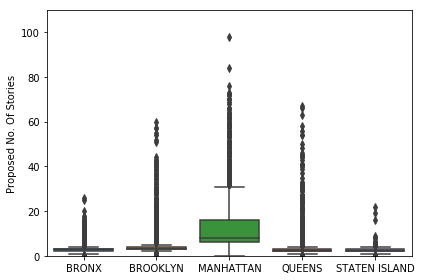

In [29]:
# Boxplot of Proposed No. Of Stories in each borough. 
ax = sns.boxplot(data=data,x='Borough', y='Proposed No. Of Stories')
ax.set(ylim=(0,110))
ax.set_xlabel('')
plt.tight_layout()

/Users/anushavan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(-2.45,0.5,'Duration (days)')

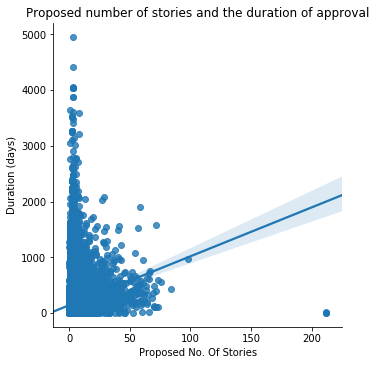

In [30]:
# scatterplot of proposed number of stories and duration.

sns.lmplot(x='Proposed No. Of Stories', y='Duration', data=data)
plt.title('Proposed number of stories and the duration of approval')
plt.ylabel('Duration (days)')

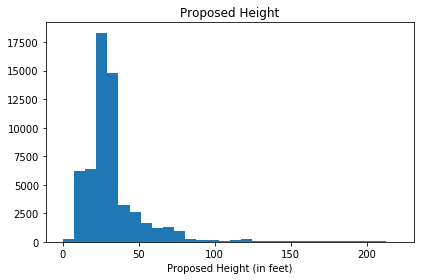

In [31]:
# Histogram of Proposed Height. 
ax = data['Proposed Height'].hist(bins=30, range=(0,220))
ax.set_title('Proposed Height')
ax.set_xlabel('Proposed Height (in feet)')
ax.grid(False)
pd.DataFrame((data['Proposed Height']).describe()).round(1)
plt.tight_layout()

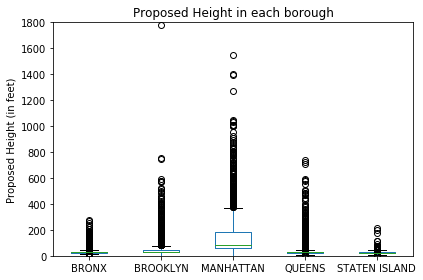

In [32]:
# Boxplot of Proposed Height in each borough. 
# ax = sns.boxplot(data=data,x='Borough', y='Proposed Height')
ax = data.boxplot(column='Proposed Height', by='Borough')
ax.set(ylim=(0,1800))
ax.set_xlabel('')
ax.set_ylabel('Proposed Height (in feet)')
ax.set_title('Proposed Height in each borough')
plt.suptitle('')
ax.grid(False)
plt.tight_layout()

/Users/anushavan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 5100)

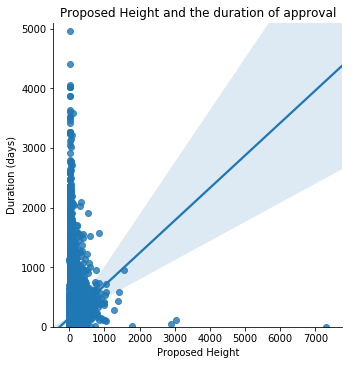

In [33]:
# scatterplot of proposed height and duration.

sns.lmplot(x='Proposed Height', y='Duration', data=data)
plt.title('Proposed Height and the duration of approval')
plt.ylabel('Duration (days)')
plt.ylim(0,5100)

,Proposed Dwelling Units
count,50387.0
mean,10.1
std,103.1
min,0.0
25%,1.0
50%,2.0
75%,3.0
max,21240.0


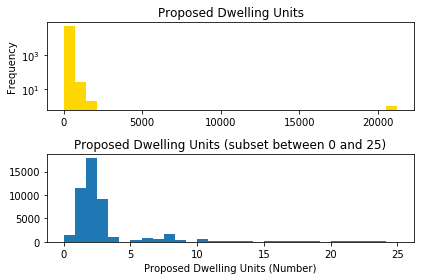

In [34]:
# Histogram of Proposed Height. 
fig,ax = plt.subplots(2,1, sharey=True)
plt.subplot(2,1,1)
ax = data['Proposed Dwelling Units'].plot(kind='hist', bins=30, color='gold', logy=True)
ax.set_title('Proposed Dwelling Units')
ax.grid(False)

plt.subplot(2,1,2)
ax1 = data['Proposed Dwelling Units'].hist(bins=30, range=(0,25))
ax1.set_title('Proposed Dwelling Units (subset between 0 and 25)')
ax1.set_xlabel('Proposed Dwelling Units (Number)')
ax1.grid(False)

plt.tight_layout()
pd.DataFrame((data['Proposed Dwelling Units']).describe()).round(1)

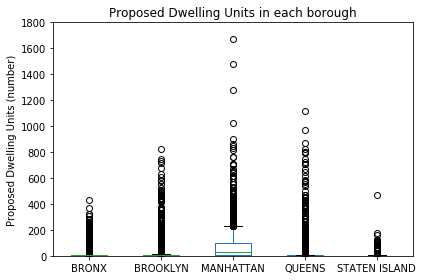

In [35]:
# Boxplot of Proposed Dwelling Units in each borough. 
ax = data.boxplot(column='Proposed Dwelling Units', by='Borough')

# ax = sns.boxplot(data=data,x='Borough', y='Proposed Dwelling Units')
ax.set(ylim=(0,1800))
ax.set_xlabel('')
ax.set_ylabel('Proposed Dwelling Units (number)')
ax.set_title('Proposed Dwelling Units in each borough')
plt.suptitle('')
ax.grid(False)
plt.tight_layout()

/Users/anushavan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 2000)

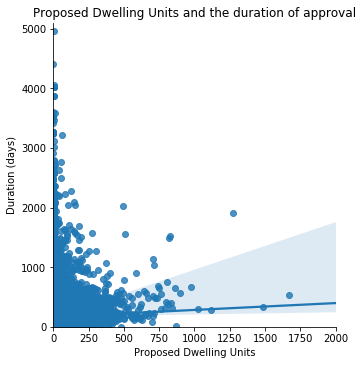

In [36]:
# scatterplot of proposed dwelling units and duration.

sns.lmplot(x='Proposed Dwelling Units', y='Duration', data=data)
plt.title('Proposed Dwelling Units and the duration of approval')
plt.ylabel('Duration (days)')
plt.ylim(0,5100)
plt.xlim(0,2000)

In [37]:
data.head(2)

,Borough,Building Type,Efiling Filed,Applicant Professional Title,Professional Cert,Fully Paid,Approved,Total Est. Fee,Proposed Zoning Sqft,Proposed No. Of Stories,...,Proposed Occupancy,Zoning Dist1,Zoning Dist2,Zoning Dist3,Special District 1,Special District 2,Non-Profit,Total_Construction_Floor_Area,Signoff_Date,Duration
0,QUEENS,1-2-3 FAMILY,Y,RA,N,2018-11-02,2019-04-09,243.00,2700,2,...,R-3,R3A,NaN,NaN,NaN,NaN,N,4050,NaT,158.0
1,BROOKLYN,OTHERS,Y,RA,N,2012-03-27,2013-03-14,52167.26,161567,14,...,R-1,M1-2/R6,NaN,NaN,MX-8,GW,N,198951,NaT,352.0


### Categorical variables that have multiple categories 

#### How to visualize the categorigal variables that have too many categories for a bar chart or box plot?

Zoning, Special Districts and Proposed Occupany variables have multiple categoris each, ranging from 8 (Special District 2) to 43 (Proposed Occupancy) to 164 (Zoning Dist1) and anything in between. 

In [38]:
data['Proposed Occupancy'].unique()

array(['R-3', 'R-1', 'U', 'R-2', 'E', 'M', 'S-2', 'J-3', 'B', 'S-1',
       'B-2', 'F-1', 'J-2', 'F-1B', 'A-3', 'J-0', 'A-4', 'PUB', 'C',
       'B-1', 'G', 'RES', 'J-1', nan, 'A-5', 'I-1', 'A-2', 'F-2', 'F-3',
       'COM', 'D-1', 'D-2', 'H-2', 'K', 'F-4', 'I-2', 'I-4', 'F-1A', 'A',
       'H-5', 'A-1', 'H-1', 'H-3'], dtype=object)

Text(0,0.5,'Days')

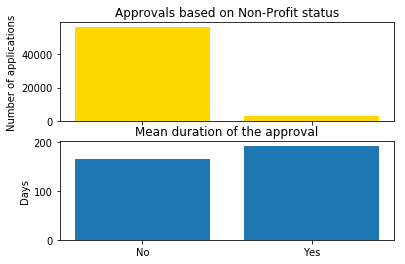

In [39]:
#bar chart of the Non-profit category.

fig, (ax1,ax2) = plt.subplots(2, sharex=True)

ngo=(data.groupby('Non-Profit')[['Approved','Duration']].
agg({'Approved':'count', 'Duration':'mean'}))

ax1.bar(ngo.index, ngo['Approved'], color='gold')
ax1.set_title('Approvals based on Non-Profit status')
ax1.set_ylabel('Number of applications')

ax2.bar(ngo.index, ngo['Duration'])
ax2.set_title('Mean duration of the approval')
ax2.set_xticklabels(['No','Yes'], rotation=360)
ax2.set_ylabel('Days')

# clarify the title and other a box plot.


,Total_Construction_Floor_Area
count,59076.0
mean,13557.1
std,70007.6
min,0.0
25%,2319.0
50%,3453.0
75%,5481.2
max,7142400.0


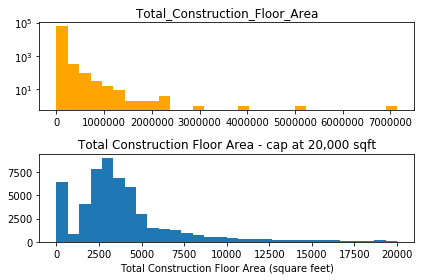

In [40]:
# Histogram of Total Construction Floor Area. 

fig,ax = plt.subplots(2,1)

plt.subplot(2,1,1)
ax = data['Total_Construction_Floor_Area'].hist(bins=30, color='orange')
ax.set_title('Total_Construction_Floor_Area')
ax.set_yscale('log')
# ax.set_xlabel('Total_Construction_Floor_Area (square feet)')
ax.grid(False)

plt.subplot(2,1,2)
ax1 = data['Total_Construction_Floor_Area'].hist(bins=30,  range=(0,20000))
ax1.set_title('Total Construction Floor Area - cap at 20,000 sqft')
ax1.set_xlabel('Total Construction Floor Area (square feet)')
ax1.grid(False)

plt.tight_layout()
pd.DataFrame((data['Total_Construction_Floor_Area']).describe()).round(1)


/Users/anushavan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 2000000)

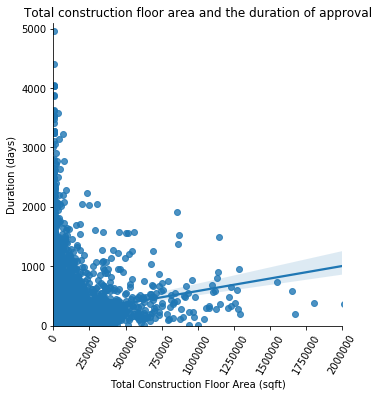

In [41]:
# scatterplot of Total construction floor area and duration.

sns.lmplot(x='Total_Construction_Floor_Area', y='Duration', data=data)
plt.title('Total construction floor area and the duration of approval')
plt.ylabel('Duration (days)')
plt.xlabel('Total Construction Floor Area (sqft)')
plt.ylim(0,5100)
plt.xticks(rotation=60)
plt.xlim(0,2000000)

### Further analysis of the dependent variable and explanatory variables.

Heatmap of all variables and correlations.

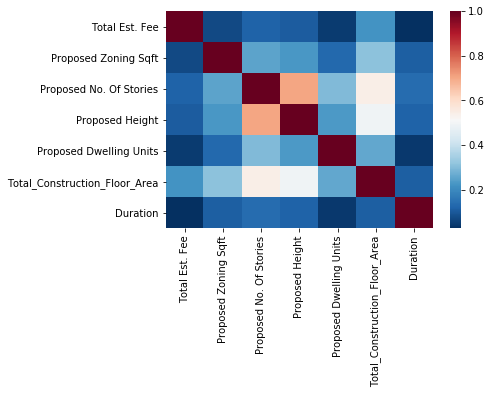

In [42]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="RdBu_r")

,Duration
count,59076.000000
mean,167.168969
std,259.648127
min,1.000000
25%,25.000000
50%,83.000000
75%,201.000000
max,4959.000000


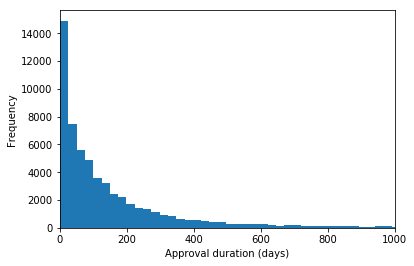

In [43]:
# Create a histogram of duration and include a statistical analysis.
data['Duration'].plot(kind='hist', bins = 200)
plt.xlim(0,1000)
plt.xlabel('Approval duration (days)')
pd.DataFrame(data['Duration'].describe())

Text(0.5,1,'Mean and median duration by borough')

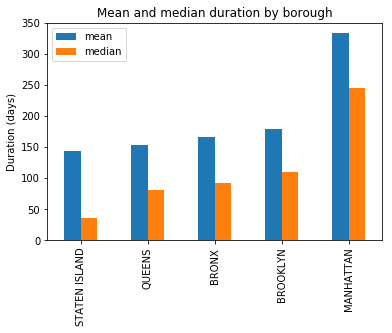

In [44]:
ax = (data.groupby('Borough')['Duration'].agg(['mean','median'])
      .sort_values(by='mean').plot(kind='bar'))
ax.set_xlabel('')
ax.set_ylabel('Duration (days)')
ax.set_title('Mean and median duration by borough')

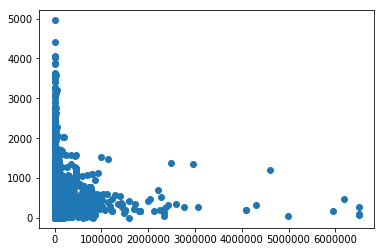

In [45]:
# scatter plot of Proposed Zoning Sqft (x) Duration (y) 
plt.scatter(x=data['Proposed Zoning Sqft'], y=data['Duration'])

### Selecting outliers

Selecting outliers based on the Duration variable. Applying a filter to
select values that are +- 3 standard deviation in this variable. Total number of outliers is
1242 data points, which is 2.1% of the total data.

In [46]:
from scipy.stats import zscore

In [47]:
data['Z_score'] = zscore(data['Duration'])

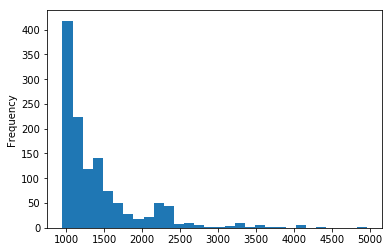

In [48]:
data[data['Z_score'] > 3]['Duration'].plot(kind='hist', bins=30)
# x axis labels add

### Aggregate proposed occupancy, zoning & special district categories into larger groups

* Zoning Districts 1,2 and 3 are mainly in Queens

In [49]:
# create a list with values to replace with 'OTHER'
other_occupancy = []
for k,v in data['Proposed Occupancy'].value_counts().items():
    if v < 500:
        other_occupancy.append(k)

In [50]:
# replace values in the proposed occupancy that are less than 500 with 'other'
data['Proposed Occupancy'].replace(other_occupancy,'Other', inplace=True)

In [51]:
# create a list of items that are less than 50 data points 
other1 = []
for k, v in data['Zoning Dist1'].value_counts().items():
    if v < 200:
        other1.append(k)

In [52]:
# replace values in the proposed occupancy that are less than 500 with 'other'
data['Zoning Dist1'].replace(other1,'Other', inplace=True)

Text(0,0.5,'Number of applications')

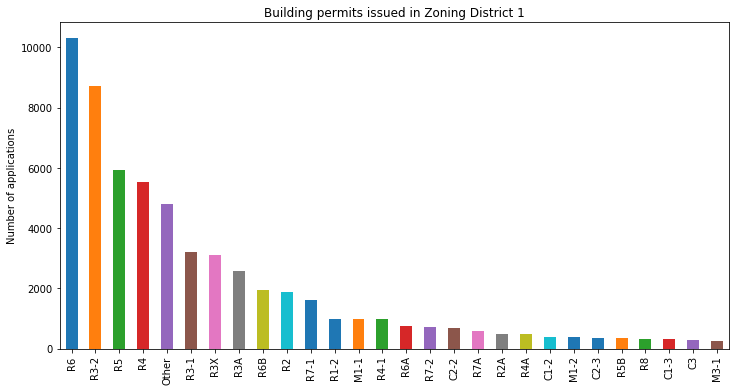

In [53]:
# bar plot of the new zoning district 1 values
ax = data['Zoning Dist1'].value_counts().plot(kind='bar',figsize=(12,6))
ax.set_title('Building permits issued in Zoning District 1')
ax.set_ylabel('Number of applications')

In [54]:
! pip install squarify

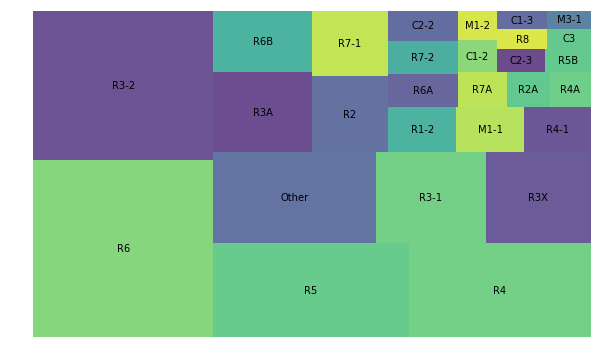

In [55]:
import squarify
ax = squarify.plot(sizes=data['Zoning Dist1'].value_counts().values, 
              label=data['Zoning Dist1'].value_counts().index, alpha=.8)
plt.axis('off')
ax.figure.set_size_inches(10,6)

In [56]:
other2 = []

for k,v in data['Zoning Dist2'].value_counts().items():
    if v < 30:
        other2.append(k)

In [57]:
data['Zoning Dist2'] = data['Zoning Dist2'].replace(other2, 'Other')

#### Zoning Dist2 variable has 54356 NaN values out of total 59076 (~ 8% of values are not NaN) 
##### Aggregated all categories that have less than 30 entries into "Other" category, which has now 559 entries.

In [58]:
other_Dist1 = []
for k,v in data['Special District 1'].value_counts().items():
    if v < 30:
        other_Dist1.append(k)

In [59]:
data['Special District 1'] = data['Special District 1'].replace(other_Dist1, 'Other')

In [60]:
data['Special District 1'].value_counts()

SRD      2138
SR       1076
OP        465
Other     423
HS        229
LIC       210
MX-8      178
NA-1      157
CD         88
MID        80
DB         73
H          73
BR         72
DJ         64
SB         44
CL         43
WCH        37
LM         36
HY         32
Name: Special District 1, dtype: int64

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59076 entries, 0 to 118460
Data columns (total 23 columns):
Borough                          59076 non-null category
Building Type                    59076 non-null object
Efiling Filed                    59076 non-null object
Applicant Professional Title     59076 non-null object
Professional Cert                59076 non-null object
Fully Paid                       59076 non-null datetime64[ns]
Approved                         59076 non-null datetime64[ns]
Total Est. Fee                   59076 non-null float64
Proposed Zoning Sqft             59076 non-null int64
Proposed No. Of Stories          59076 non-null int64
Proposed Height                  59076 non-null int64
Proposed Dwelling Units          50387 non-null float64
Proposed Occupancy               58902 non-null object
Zoning Dist1                     58903 non-null object
Zoning Dist2                     4720 non-null object
Zoning Dist3                     202 non-null obj

In [62]:
data['Zoning Dist3'].value_counts()

R6          26
R6B         20
R3-2        16
R5          14
C1-4        10
M1-1         9
R7A          8
R4           8
C1-2         7
R7-1         7
M1-2         6
R4-1         5
R6A          5
R8           5
R8A          4
R7-3         3
R9           3
C6-6         3
R7-2         3
R3-1         3
C2-2         3
C2-4         3
M1-4         2
R7X          2
R5B          2
R2           2
R10          1
M1-5         1
C4-4A        1
C6-6.5       1
C8-2         1
C6-4.5       1
M1-2/R6A     1
R10A         1
R9A          1
C4-2         1
C6-4         1
R7B          1
C6-4M        1
C2-1         1
R5D          1
C4-4D        1
R8B          1
C8-1         1
C6-1         1
C6-3A        1
C2-3         1
C6-5.5       1
C4-2A        1
Name: Zoning Dist3, dtype: int64

### How to deal with these 4 zoning variables that have very few valid cells 
#### (especially Zoning Dist3 and Special District 2)

Zoning Dist2 -- 4720 non-null object

Zoning Dist3 -- 202 non-null object

Special District 1 -- 5518 non-null object

Special District 2 -- 600 non-null object
